#Storytelling - [Reserva de hoteles](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)

Los canales de reserva de hoteles han experimentado un cambio significativo en la cantidad de cancelaciones de reservas por parte de los clientes. Es un hecho de que la cancelación de forma gratuita o, preferiblemente, a un bajo costo, es beneficioso para los huéspedes del hotel, pero es un factor menos deseable y que posiblemente disminuya los ingresos para los hoteles.

El área de Data & Analytics de una empresa de reserva de hoteles busca encontrar las características en común de aquellos clientes que cancelan las reservas mediante el análisis exploratorio de datos y sus respectivas visualizaciones. Además (para más adelante) se buscará predecir que clientes podrían realizar una cancelación en la reserva solicitada a partir de algoritmos de machine learning.

El equipo de contabilidad nos ha proporcionado datos sobre todas las reservas realizadas por 36275 personas para los años 2017 y 2018.

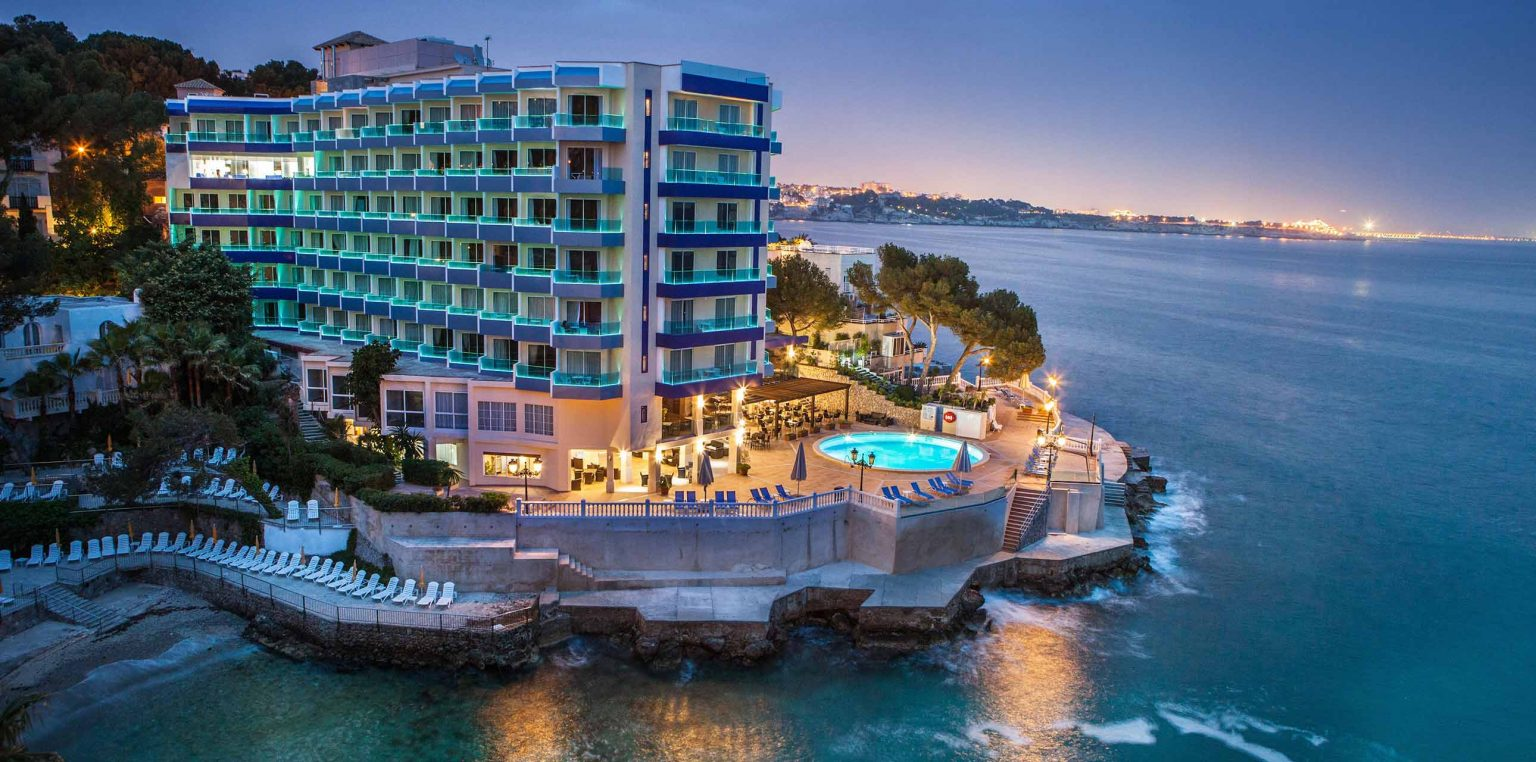

In [98]:
# Importo las librerías

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import prince
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")




## **Descripción del Dataset**
#####El dataset se compone de 36275 filas y 18 columnas, sin contar la columna Booking_ID que se utilizará como índice del DataFrame.

####**Indice**:

*   Booking_ID: Identificador único para cada reserva

####**Columnas**:

*   no_of_adults: Número de adultos asociados en la reserva.
*   no_of_children: Número de menores de edad asociados a la reserva.
*   no_of_weekend_nights: Número de noches de fin de semana asociado a la reserva.
*   no_of_week_nights: Número de noches de día de semana asociado a la reserva.
*   type_of_meal_plan: Tipo de plan de comidas elegido por el usuario.
*   required_car_parking_space: El ususario contrató servicio de parking? (0 - No, 1- Si).
*   room_type_reserved: Tipo de habitación contratada.
*   lead_time: Número de días entre la fecha de reserva y la fecha de llegada al hotel.
*   arrival_year: Año de llegada.
*   arrival_month: Mes de llegada.
*   arrival_date: Día de llegada.
*   market_segment_type: Designación de segmento de mercado (si la reserva fue hecha online, offline u otros).
*   repeated_guest: Si el usuario es un huesped repetido (0 - No, 1- Si)
*   no_of_previous_cancellations: Número de cancelaciones previas.
*   no_of_previous_bookings_not_canceled: Número de reservas previas que no fueron canceladas por el usuario.
*   avg_price_per_room: Prcio promedio por habitación.
*   no_of_special_requests: Número de solicitudes especiales realizadas por el usuario.
*   booking_status: Estado de la reserva (Cancelada, No cancelada).














In [2]:
path_archivo = r'C:\Users\54112\Desktop\Cursos\Coderhouse\DataScience\proyecto_data_science\Hotel Reservations.csv' # Cambiar Ruta 
df_reserva_hoteles = pd.read_csv(path_archivo, index_col=0) # Asocio el Booking ID al índice del DataFrame

In [3]:
df_reserva_hoteles.info() # En principio, no habría valores nulos.

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_seg

In [4]:
print(f'La variable required_car_parking_space admite los valores: {df_reserva_hoteles.required_car_parking_space.unique()} por lo tanto la considero categórica\n')
print(f'Lo mismo sucede para la variable repeated_guest: {df_reserva_hoteles.repeated_guest.unique()}')

La variable required_car_parking_space admite los valores: [0 1] por lo tanto la considero categórica

Lo mismo sucede para la variable repeated_guest: [0 1]


In [5]:
# Lista de variables categóricas
categorical_vars = df_reserva_hoteles.select_dtypes(include=['object']).columns.tolist() + ['repeated_guest', 'required_car_parking_space']
categorical_vars.remove('booking_status')
# Convertir las variables object a tipo 'category'
df_reserva_hoteles[categorical_vars] = df_reserva_hoteles[categorical_vars].astype('category')

In [6]:
categorical_vars

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'repeated_guest',
 'required_car_parking_space']

In [7]:
df_reserva_hoteles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   no_of_weekend_nights                  36275 non-null  int64   
 3   no_of_week_nights                     36275 non-null  int64   
 4   type_of_meal_plan                     36275 non-null  category
 5   required_car_parking_space            36275 non-null  category
 6   room_type_reserved                    36275 non-null  category
 7   lead_time                             36275 non-null  int64   
 8   arrival_year                          36275 non-null  int64   
 9   arrival_month                         36275 non-null  int64   
 10  arrival_date                          36275 non-null  int64   
 1

In [8]:
categorical_vars.append('booking_status')
categorical_vars

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'repeated_guest',
 'required_car_parking_space',
 'booking_status']

In [9]:
def valores_unicos(df):
    """Esta función crea un diccionario con las variables categoricas y sus valores únicos, sirve para
    ver si los valores categoricos están bien escritos y no hay por ejemplo, nombres con errores de ortografía o
    valores erroenos
    """
    
    valores_unicos_variables_categoricas = {variable: list(df[variable].unique()) for variable in categorical_vars}
    return valores_unicos_variables_categoricas

In [10]:
valores_unicos(df_reserva_hoteles)

{'type_of_meal_plan': ['Meal Plan 1',
  'Not Selected',
  'Meal Plan 2',
  'Meal Plan 3'],
 'room_type_reserved': ['Room_Type 1',
  'Room_Type 4',
  'Room_Type 2',
  'Room_Type 6',
  'Room_Type 5',
  'Room_Type 7',
  'Room_Type 3'],
 'market_segment_type': ['Offline',
  'Online',
  'Corporate',
  'Aviation',
  'Complementary'],
 'repeated_guest': [0, 1],
 'required_car_parking_space': [0, 1],
 'booking_status': ['Not_Canceled', 'Canceled']}

In [11]:
df_reserva_hoteles.head(4) # Observo los primeros 4 registros

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled


In [12]:
df_reserva_hoteles.index.duplicated().sum() # Veo si el Id (los índices) están duplicados

0

In [13]:
df_reserva_hoteles.describe().round(2) # Breve resumen de valores estadísticos de variables numéricas.

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00
mean,1.84,0.11,0.81,2.20,85.23,2017.82,7.42,15.60,0.02,0.15,103.42,0.62
std,0.52,0.40,0.87,1.41,85.93,0.38,3.07,8.74,0.37,1.75,35.09,0.79
min,0.00,0.00,0.00,0.00,0.00,2017.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,1.00,17.00,2018.00,5.00,8.00,0.00,0.00,80.30,0.00
50%,2.00,0.00,1.00,2.00,57.00,2018.00,8.00,16.00,0.00,0.00,99.45,0.00
75%,2.00,0.00,2.00,3.00,126.00,2018.00,10.00,23.00,0.00,0.00,120.00,1.00
max,4.00,10.00,7.00,17.00,443.00,2018.00,12.00,31.00,13.00,58.00,540.00,5.00


In [14]:
print(f'El DataFrame del DataSet Hotel Reservations Dataset tiene:  {df_reserva_hoteles.shape[0]} filas y {df_reserva_hoteles.shape[1]} columnas')
print(f'El DataFrame es de dimensión {df_reserva_hoteles.ndim} y tiene una cantidad total de {df_reserva_hoteles.size} elementos')

El DataFrame del DataSet Hotel Reservations Dataset tiene:  36275 filas y 18 columnas
El DataFrame es de dimensión 2 y tiene una cantidad total de 652950 elementos


In [15]:
print(f'Valores nulos por columna: \n \n{df_reserva_hoteles.isnull().sum()}') # Observo si hay valores nulos en cada columna del df

Valores nulos por columna: 
 
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


##Objetivos


Realizar un análisis exploratorio de los datos para investigar visualmente la estructura de los datos y conocer si hay diferencia en aquellos usuarios que realizan cancelaciones en las reservas vs los usuarios que no realizan cancelaciones.

Responder las siguientes preguntas:



1.   ¿Hay un aumento de reservas con el tiempo? ¿Que porcentaje de reservas fueron canceladas por año?
2.   ¿El precio promedio por habitación es mayor en las reservas canceladas que en aquellas que se concretan?
1.   ¿Se observan datos anomalos (Outliers)?
1.   ¿Las reservas son en la mayoría hechas por familias o  por parejas sin niños?
2. ¿Existen huespedes que ya hayan cancelado previamente?
2.   ¿Se podrían detectar que reservas podrían ser canceladas y cuales no? Esta pregunta se responderá más adelante con los algoritmos de machine learning.






## Análisis Exploratorio de Datos

In [16]:
plt.style.use('Solarize_Light2')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.style'] = 'oblique'

### Evolución de las reservas en el año 2017 y 2018

In [17]:
meses = {1:'Ene', 2:'Feb', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dic'}

In [18]:
# Realizo una Serie para contar los valores por año y los ordeno por el índice de la Serie (es decir, por año)
arribos_por_anio = df_reserva_hoteles.arrival_year.value_counts().sort_index() # Devuelve un objeto de tipo Serie

# Realizo una Serie para contar los valores por mes y los ordeno por el índice de la Serie (es decir, por mes)
arribo_por_mes = df_reserva_hoteles.arrival_month.value_counts().sort_index()

arribo_por_mes.rename(index=meses, inplace=True)

In [19]:
# Filtro el DataFrame original por el año 2017 y 2018 y los guardo en otros dos para luego gráficar la cantidad de reservas por año con pyplot.

df_reserva_hoteles_2017 = df_reserva_hoteles.loc[df_reserva_hoteles['arrival_year'] == 2017, :] # Filtro por el año 2017

df_reserva_hoteles_2018 = df_reserva_hoteles.loc[df_reserva_hoteles['arrival_year'] == 2018, :] # Filtro por el año 2018

arribo_por_mes_2017 = df_reserva_hoteles_2017.arrival_month.value_counts().sort_index() # Esto me devuelve una Serie

arribo_por_mes_2018 = df_reserva_hoteles_2018.arrival_month.value_counts().sort_index() # Esto me devuelve una Serie

# A continuación le cambio los índices a la serie para que sea más legible
arribo_por_mes_2017.rename(index=meses, inplace=True)
arribo_por_mes_2018.rename(index=meses, inplace=True)

In [20]:
# Calculo nunericamente la cantidad y porcentaje de las reservas que fueron canceladas y de aquellas que no fueron canceladas.

cantidad_reservas_no_canceladas = df_reserva_hoteles.booking_status.value_counts()[0]
cantidad_reservas_canceladas = df_reserva_hoteles.booking_status.value_counts()[1]

porcenaje_reservas_no_canceladas = (df_reserva_hoteles.booking_status.value_counts()[0]*100/(cantidad_reservas_no_canceladas+cantidad_reservas_canceladas)).round(2)
porcenaje_reservas_canceladas = (df_reserva_hoteles.booking_status.value_counts()[1]*100/(cantidad_reservas_no_canceladas+cantidad_reservas_canceladas)).round(2)

print(f'La cantidad de reservas canceladas es de {cantidad_reservas_canceladas} ({porcenaje_reservas_canceladas}%)\nLa cantidad de reservas no canceladas es de {cantidad_reservas_no_canceladas} ({porcenaje_reservas_no_canceladas}%)')

La cantidad de reservas canceladas es de 11885 (32.76%)
La cantidad de reservas no canceladas es de 24390 (67.24%)


In [21]:
# En el siguiente bloque se calcula el porcentaje de reservas canceladas en el año 2017 y 2018

cantidad_reservas_canceladas_anio_2017 = df_reserva_hoteles.loc[(df_reserva_hoteles['arrival_year'] == 2017) & (df_reserva_hoteles['booking_status'] == 'Canceled'), ['booking_status']].count()
cantidad_reservas_canceladas_anio_2018 = df_reserva_hoteles.loc[(df_reserva_hoteles['arrival_year'] == 2018) & (df_reserva_hoteles['booking_status'] == 'Canceled'), ['booking_status']].count()

cantidad_total_reservas_anio_2017 = df_reserva_hoteles_2017.booking_status.count()
cantidad_total_reservas_anio_2018 = df_reserva_hoteles_2018.booking_status.count()

porcentaje_reservas_canceladas_2017 = round(100*cantidad_reservas_canceladas_anio_2017/cantidad_total_reservas_anio_2017, 2)
porcentaje_reservas_canceladas_2018 = round(100*cantidad_reservas_canceladas_anio_2018/cantidad_total_reservas_anio_2018, 2)
print(f'El porcenaje de reservas canceladas en el 2017 fue del {porcentaje_reservas_canceladas_2017[0]} % y en el 2018 del {porcentaje_reservas_canceladas_2018[0]} %, por lo que hubo un aumento en las cancelaciones del {porcentaje_reservas_canceladas_2018[0]-porcentaje_reservas_canceladas_2017[0]} %')

El porcenaje de reservas canceladas en el 2017 fue del 14.75 % y en el 2018 del 36.71 %, por lo que hubo un aumento en las cancelaciones del 21.96 %


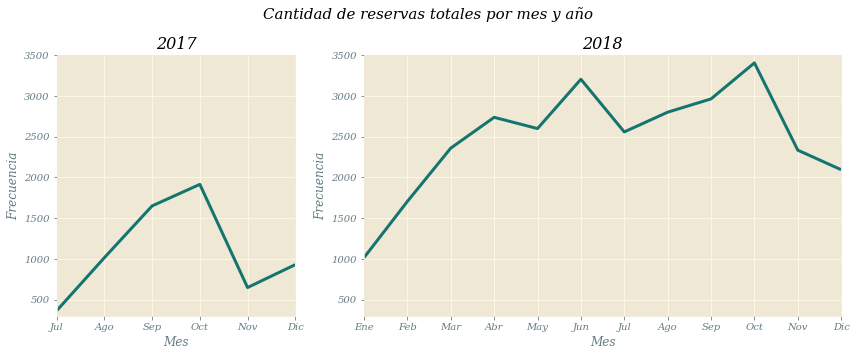

Se puede observar que en el 2018 aumentaron la cantidad de reservas para cada mes en comparación del año 2017.
Además, no hay datos en los meses previos a Julio para el año 2017.
El mes con mayor cantidad de reservas, tanto para 2017 y 2018 es octubre


In [22]:
# Realizo las gráficas con el método ortientado a objetos de matplotlib. En particular de un lineplot por año de frecuencia de reservas vs mes.
# Crear una figura con un GridSpec personalizado
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, width_ratios=[2, 4])  # Dos columnas de igual ancho

# Título de la figura
plt.suptitle('Cantidad de reservas totales por mes y año')

# Definir los ejes
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


plt.suptitle('Cantidad de reservas totales por mes y año', fontsize=15)
ax1.plot(arribo_por_mes_2017.index.astype('str'), arribo_por_mes_2017, color='#14746f', linewidth=3)
ax2.plot(arribo_por_mes_2018.index.astype('str'), arribo_por_mes_2018, color='#14746f', linewidth=3)


# Configurar los límites del eje y en ambos subgráficos
y_lim = (300, 3500)
ax1.set_ylim(y_lim)
ax2.set_ylim(y_lim)

ax1.set_ylabel('Frecuencia')
ax1.set_xlabel('Mes')
ax1.set_xlim(arribo_por_mes_2017.index.astype('str')[0], arribo_por_mes_2017.index.astype('str')[-1])
ax1.set_title('2017')

ax2.set_ylabel('Frecuencia')
ax2.set_xlabel('Mes')
ax2.set_xlim(arribo_por_mes_2018.index.astype('str')[0], arribo_por_mes_2018.index.astype('str')[-1])
ax2.set_title('2018')
plt.tight_layout()
plt.show()

print('Se puede observar que en el 2018 aumentaron la cantidad de reservas para cada mes en comparación del año 2017.\nAdemás, no hay datos en los meses previos a Julio para el año 2017.\nEl mes con mayor cantidad de reservas, tanto para 2017 y 2018 es octubre')

Mayor cantidad de registros en el año 2018


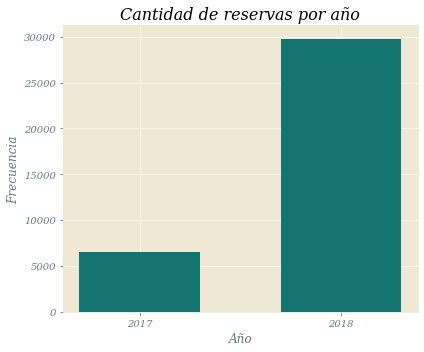

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

ax.bar(arribos_por_anio.index.astype('str'), arribos_por_anio, color='#14746f', width=0.6)
ax.set_title('Cantidad de reservas por año')
ax.set_ylabel('Frecuencia')
ax.set_xlabel('Año');
plt.tight_layout()
print('Mayor cantidad de registros en el año 2018')
plt.show()


In [24]:

# Agrupar y contar reservas canceladas y no canceladas por año y mes
df_grouped = df_reserva_hoteles.groupby(['arrival_year', 'arrival_month', 'booking_status']).size().reset_index(name='count')
df_grouped['arrival_month'] = df_grouped['arrival_month'].map(meses)

In [25]:
df_cancelado_2017 = df_grouped[(df_grouped['arrival_year'] == 2017) & (df_grouped['booking_status'] == 'Canceled')]
df_no_cancelado_2017 = df_grouped[(df_grouped['arrival_year'] == 2017) & (df_grouped['booking_status'] == 'Not_Canceled')]
df_cancelado_2018 = df_grouped[(df_grouped['arrival_year'] == 2018) & (df_grouped['booking_status'] == 'Canceled')]
df_no_cancelado_2018 = df_grouped[(df_grouped['arrival_year'] == 2018) & (df_grouped['booking_status'] == 'Not_Canceled')]


In [26]:
df_cancelado_2017 = df_cancelado_2017.reset_index(drop=True)
df_no_cancelado_2017 = df_no_cancelado_2017.reset_index(drop=True)
df_cancelado_2018 = df_cancelado_2018.reset_index(drop=True)
df_no_cancelado_2018 = df_no_cancelado_2018.reset_index(drop=True)


In [27]:
df_tasa_cancelaciones_por_mes_2017 = df_cancelado_2017[['arrival_month']]
df_tasa_cancelaciones_por_mes_2017['tasa_cancelaciones'] = (df_cancelado_2017['count']/(df_cancelado_2017['count'] + df_no_cancelado_2017['count'])).round(2)

df_tasa_cancelaciones_por_mes_2018 = df_cancelado_2018[['arrival_month']]
df_tasa_cancelaciones_por_mes_2018['tasa_cancelaciones'] = (df_cancelado_2018['count']/(df_cancelado_2018['count'] + df_no_cancelado_2018['count'])).round(2)

El eje y representa la cantidad de reservas canceladas para cada mes sobre el total de reservas registradas por mes
Se puede observar que la tasa disminuye hacia el final de cada año y es máxima entre julio y agosto
En el caso del 2018 hay una tendencia alcista desde inicios de año hasta mitad de año aproximadamente


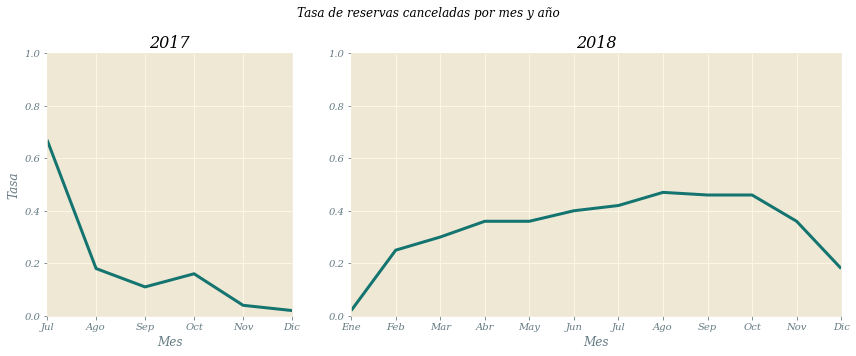

In [28]:
# Crear una figura con un GridSpec personalizado
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, width_ratios=[2, 4])  # Dos columnas de igual ancho

# Título de la figura
plt.suptitle('Tasa de reservas canceladas por mes y año')

# Definir los ejes
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.lineplot(data=df_tasa_cancelaciones_por_mes_2017, x='arrival_month', y='tasa_cancelaciones', ax=ax1, color='#14746f', linewidth=3)
sns.lineplot(data=df_tasa_cancelaciones_por_mes_2018, x='arrival_month', y='tasa_cancelaciones', ax=ax2, color='#14746f', linewidth=3)
ax1.set_xlim(0,len(df_tasa_cancelaciones_por_mes_2017.arrival_month.unique())-1)
ax1.set_title('2017')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Tasa')
ax1.set_ylim(0,1)

ax2.set_xlim(0,len(df_tasa_cancelaciones_por_mes_2018.arrival_month.unique())-1)
ax2.set_ylim(0,1)
ax2.set_title('2018')
ax2.set_xlabel('Mes')
ax2.set_ylabel(' ')

print('El eje y representa la cantidad de reservas canceladas para cada mes sobre el total de reservas registradas por mes\nSe puede observar que la tasa disminuye hacia el final de cada año y es máxima entre julio y agosto\nEn el caso del 2018 hay una tendencia alcista desde inicios de año hasta mitad de año aproximadamente')

plt.tight_layout()
plt.show()


### Distribución de variables continuas y datos anómalos (Outliers)

Al cuantificar la cantidad de datos anómalos de las variables continuas, se contabilizaron:


*   1696 (4.68%) registros anómalos asociados a la variable precio promdedio por habitación
*   1331 (3.67%) registros anómalos asociados a la variable reserva de tiempo de entrega o lead time

Como el porcentaje de los datos anómalos es relativamente chico respecto al total de registros, se decidió no excluir estos registros del análisis.



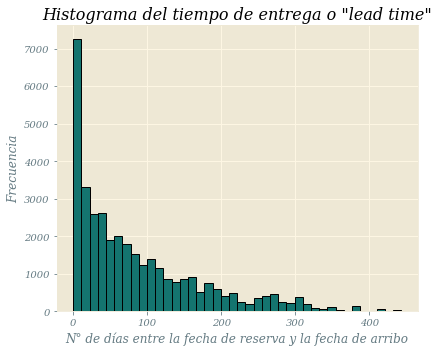

Analizando el histograma, se puede ver que la diferencia entre la fecha de llegada y la fecha de reserva puede llegar 
a valores de 400 en los casos extremos. Sin embargo, la mayor concentración de los datos se encuentra para valores menores a 100. 
El máximo se observa entre 0 y 20 días.



In [29]:
fig, ax = plt.subplots(figsize=(6,5))

ax.hist(df_reserva_hoteles['lead_time'].values.flatten(), bins=40, color='#14746f', edgecolor='black')
ax.set_title('Histograma del tiempo de entrega o "lead time"')
ax.set_ylabel('Frecuencia')
ax.set_xlabel('N° de días entre la fecha de reserva y la fecha de arribo')

plt.tight_layout()
plt.show()

print('Analizando el histograma, se puede ver que la diferencia entre la fecha de llegada y la fecha de reserva puede llegar \na valores de 400 en los casos extremos. Sin embargo, la mayor concentración de los datos se encuentra para valores menores a 100. \nEl máximo se observa entre 0 y 20 días.\n')

<!-- ### Visualizaciones -->

In [30]:
def contar_outliers(dataframe):
    """Esta función calcula y cuenta la cantidad de outliers en las columnas 
    numéricas continuas específicas del DataFrame, utilizando el método del rango 
    intercuartílico extendido para identificar valores atípicos.

    Args:
        Dataframe

    Returns:
        Diccionario con las variables numéricas continuas y la cantidad de outliers
    """
    outliers = {}
    for columna in ['lead_time', 'avg_price_per_room']:
        if np.issubdtype(dataframe[columna].dtype, np.number):  # Comprueba si la columna es numérica
            q1 = dataframe[columna].quantile(0.25)
            q3 = dataframe[columna].quantile(0.75)
            rango_intercuartilico = q3 - q1
            limite_inferior = q1 - 1.5 * rango_intercuartilico
            limite_superior = q3 + 1.5 * rango_intercuartilico
            outliers[columna] = len(dataframe[(dataframe[columna] < limite_inferior) | (dataframe[columna] > limite_superior)])
    return outliers

In [31]:
contar_outliers(df_reserva_hoteles)

{'lead_time': 1331, 'avg_price_per_room': 1696}

In [32]:
outliers_por_variable = contar_outliers(df_reserva_hoteles)
print(f'El porcentaje de outliers de la variable precio promdedio por habitación es de: {round(outliers_por_variable["avg_price_per_room"]/df_reserva_hoteles.shape[0]*100,2)}%')
print(f'El porcentaje de outliers de la variable reserva de tiempo de entrega o lead time es de: {round(outliers_por_variable["lead_time"]/df_reserva_hoteles.shape[0]*100,2)}%')


El porcentaje de outliers de la variable precio promdedio por habitación es de: 4.68%
El porcentaje de outliers de la variable reserva de tiempo de entrega o lead time es de: 3.67%


In [33]:
# Separo el DataFrame original en dos, uno por las reservas canceladas y otro para las reservas No canceladas

df_reserva_hoteles_No_Cancelados = df_reserva_hoteles.loc[df_reserva_hoteles['booking_status'] == 'Not_Canceled', :]
df_reserva_hoteles_Cancelados = df_reserva_hoteles.loc[df_reserva_hoteles['booking_status'] == 'Canceled', :]
mediana_avg_precio_habitacion_No_Cancelado = np.median(df_reserva_hoteles_No_Cancelados.avg_price_per_room.values)
mediana_avg_precio_habitacion_Cancelado = np.median(df_reserva_hoteles_Cancelados.avg_price_per_room.values)

In [34]:
print('El promedio de pedidos especiales para las reservas no canceladas es: ', round(df_reserva_hoteles_No_Cancelados.no_of_special_requests.mean(), 2))
print('El promedio de pedidos especiales para las reservas no canceladas es: ', round(df_reserva_hoteles_Cancelados.no_of_special_requests.mean(),2))

El promedio de pedidos especiales para las reservas no canceladas es:  0.76
El promedio de pedidos especiales para las reservas no canceladas es:  0.33


Se observa en el histograma y en el boxplot que la mediana del precio promedio por habitación
para las reservas canceladas está corrida a la derecha con respecto la mediana correspondiente
a las reservas no canceladas.
Valor para la mediana en el caso de que la reserva no haya sido cancelada: 95.0
Valor para la mediana en el caso de que la reserva si haya sido cancelada: 108.0


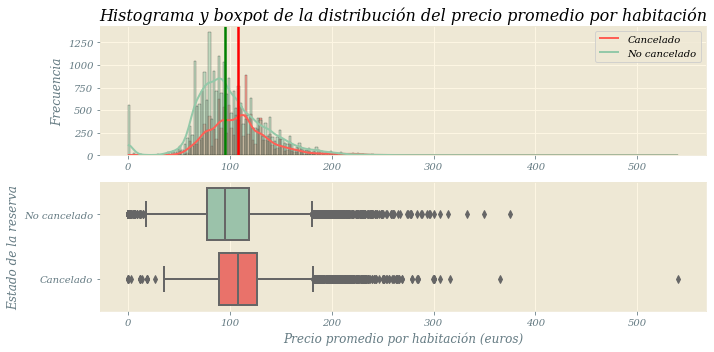

In [35]:
f, axs = plt.subplots(2, 1, figsize=(10, 5))
ax1 = sns.histplot(data=df_reserva_hoteles, x='avg_price_per_room', hue='booking_status', kde=True, palette=['#94c9a9', '#fe5f55'], ax=axs[0])
# Ploteo una línea vertical en la de las medianas calculadas.
ax1.axvline(x=mediana_avg_precio_habitacion_No_Cancelado, color='g', linewidth=2.5)
ax1.axvline(x=mediana_avg_precio_habitacion_Cancelado, color='r', linewidth=2.5)
ax2 = sns.boxplot(data=df_reserva_hoteles, x='avg_price_per_room', y='booking_status', palette=['#94c9a9', '#fe5f55'], ax=axs[1])
ax1.set(xlabel=None, ylabel='Frecuencia', title= 'Histograma y boxpot de la distribución del precio promedio por habitación')
ax2.set(xlabel='Precio promedio por habitación (euros)', ylabel='Estado de la reserva', yticklabels=['No cancelado', 'Cancelado'])
ax1.legend(labels=['Cancelado', 'No cancelado'])



f.tight_layout()
f.show()
print(f'Se observa en el histograma y en el boxplot que la mediana del precio promedio por habitación\npara las reservas canceladas está corrida a la derecha con respecto la mediana correspondiente\na las reservas no canceladas.')
print(f"Valor para la mediana en el caso de que la reserva no haya sido cancelada: {mediana_avg_precio_habitacion_No_Cancelado}\nValor para la mediana en el caso de que la reserva si haya sido cancelada: {mediana_avg_precio_habitacion_Cancelado}")

### Análisis de variables categóricas

In [36]:
df_reserva_hoteles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   no_of_weekend_nights                  36275 non-null  int64   
 3   no_of_week_nights                     36275 non-null  int64   
 4   type_of_meal_plan                     36275 non-null  category
 5   required_car_parking_space            36275 non-null  category
 6   room_type_reserved                    36275 non-null  category
 7   lead_time                             36275 non-null  int64   
 8   arrival_year                          36275 non-null  int64   
 9   arrival_month                         36275 non-null  int64   
 10  arrival_date                          36275 non-null  int64   
 1

In [37]:
# Analizo las variables categoricas mediantes barplots

df_reserva_hoteles.select_dtypes(include=['object', 'category']).columns

Index(['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'market_segment_type', 'repeated_guest', 'booking_status'],
      dtype='object')

Se observa que la mayoría de los usuarios eligen el tipo de comida del plan 1 y contratan habitaciones de tipo 1, siendo la reservación 
mayormente online. Por ultimo, se observa lo mencionado previamente de la gran cantidad de reservas canceladas en el grafico de barras.



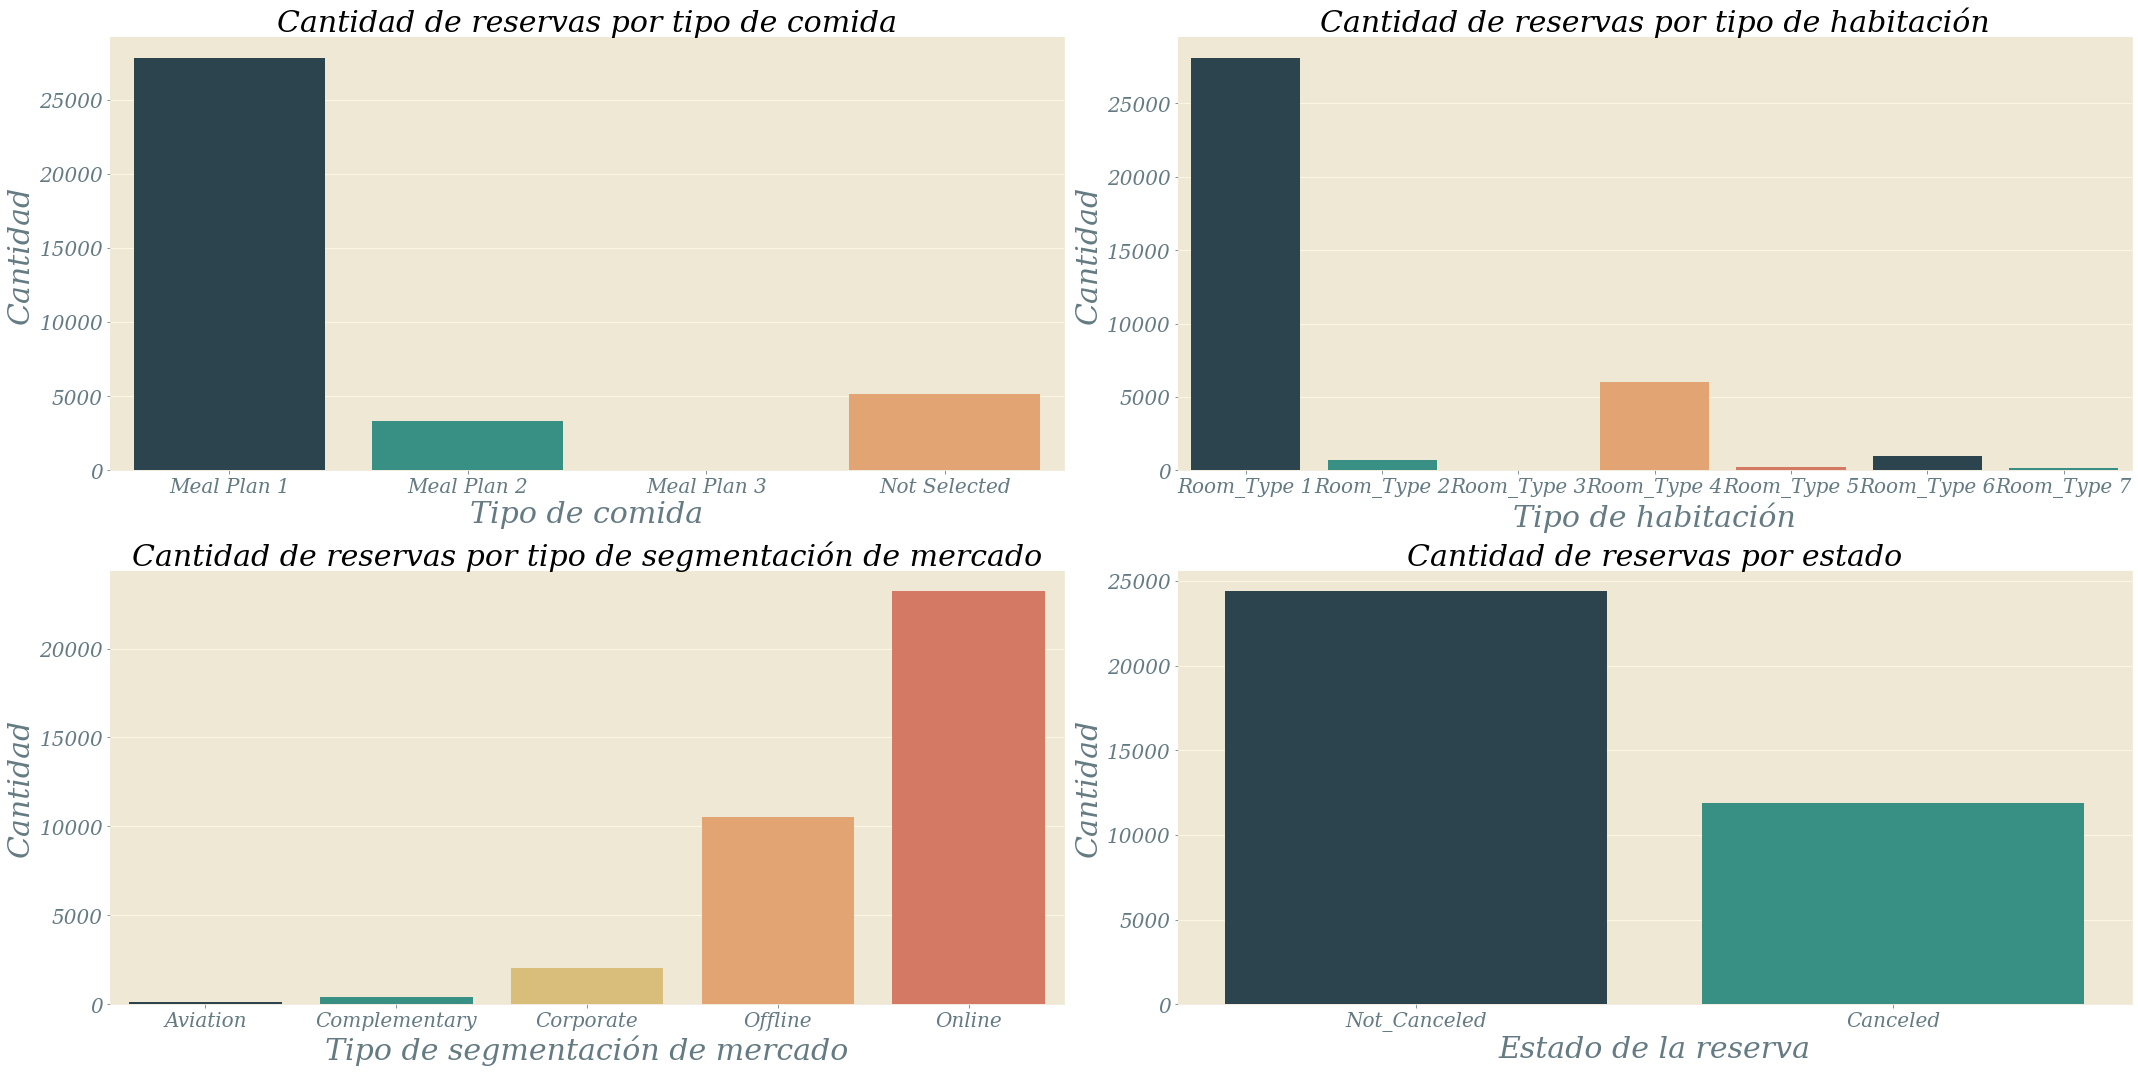

In [38]:
paleta_colores = ['#264653', '#2a9d8f','#e9c46a', '#f4a261', '#e76f51']
f, axs = plt.subplots(2, 2, figsize=(30, 15))


a1 = sns.countplot(data=df_reserva_hoteles, x='type_of_meal_plan', palette=paleta_colores, ax=axs[0,0])
a2 = sns.countplot(data=df_reserva_hoteles, x='room_type_reserved', palette=paleta_colores, ax=axs[0,1])
a3 = sns.countplot(data=df_reserva_hoteles, x='market_segment_type', palette=paleta_colores, ax=axs[1,0])
a4 = sns.countplot(data=df_reserva_hoteles, x='booking_status', palette=paleta_colores, ax=axs[1,1])

a1.set(title='Cantidad de reservas por tipo de comida')
a2.set(title='Cantidad de reservas por tipo de habitación')
a3.set(title='Cantidad de reservas por tipo de segmentación de mercado')
a4.set(title='Cantidad de reservas por estado')
a1.set_xlabel('Tipo de comida', fontsize=30)
a2.set_xlabel('Tipo de habitación', fontsize=30)
a3.set_xlabel('Tipo de segmentación de mercado', fontsize=30)
a4.set_xlabel('Estado de la reserva', fontsize=30)

for ax in axs.flat:
    ax.tick_params(labelsize=20)  # Aumentar el tamaño de la letra en los ejes
    ax.set_title(ax.get_title(), fontsize=30)  # Aumentar el tamaño de la letra en el título
    ax.set_ylabel('Cantidad', fontsize=30)

f.tight_layout()
f.show()
print('Se observa que la mayoría de los usuarios eligen el tipo de comida del plan 1 y contratan habitaciones de tipo 1, siendo la reservación \nmayormente online. Por ultimo, se observa lo mencionado previamente de la gran cantidad de reservas canceladas en el grafico de barras.\n')

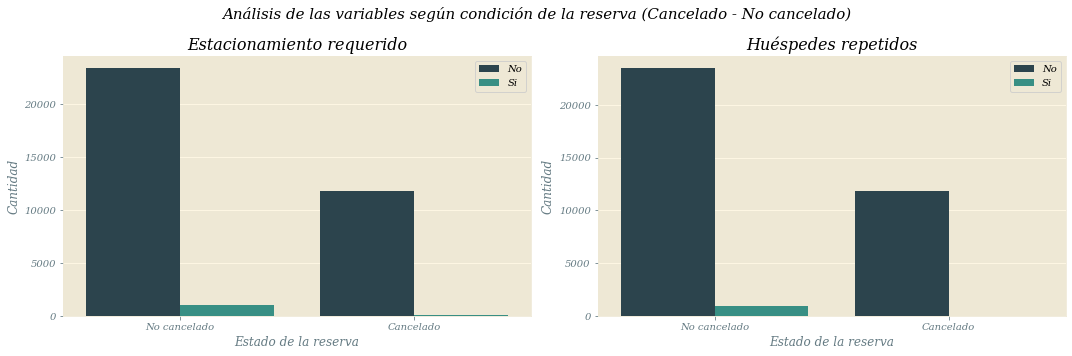

In [39]:
plt.figure(figsize = (15, 5))
plt.suptitle("Análisis de las variables según condición de la reserva (Cancelado - No cancelado)", fontsize=15)


plt.subplot(1,2,1)
ax = sns.countplot(x = 'booking_status', hue = 'required_car_parking_space', palette = paleta_colores, data = df_reserva_hoteles)
plt.title('Estacionamiento requerido')
plt.legend(labels=['No', 'Si'])
ax.set_ylabel('Cantidad')
ax.set_xlabel('Estado de la reserva')
plt.xticks(ticks=[0, 1], labels=['No cancelado', 'Cancelado'])

plt.subplot(1,2,2)
ax = sns.countplot(x = 'booking_status', hue = 'repeated_guest', palette = paleta_colores, data = df_reserva_hoteles)
plt.title('Huéspedes repetidos')
plt.legend(labels=['No', 'Si'])
ax.set_ylabel('Cantidad')
ax.set_xlabel('Estado de la reserva')
plt.xticks(ticks=[0, 1], labels=['No cancelado', 'Cancelado'])

plt.tight_layout()
plt.show()

La mayor parte de los huéspedes alquilan habitaciones para dos adultos y sin chicos. 
Existen relativamente pocos registros de reservas con chicos. 
La estadía no suele superar más de una semana.



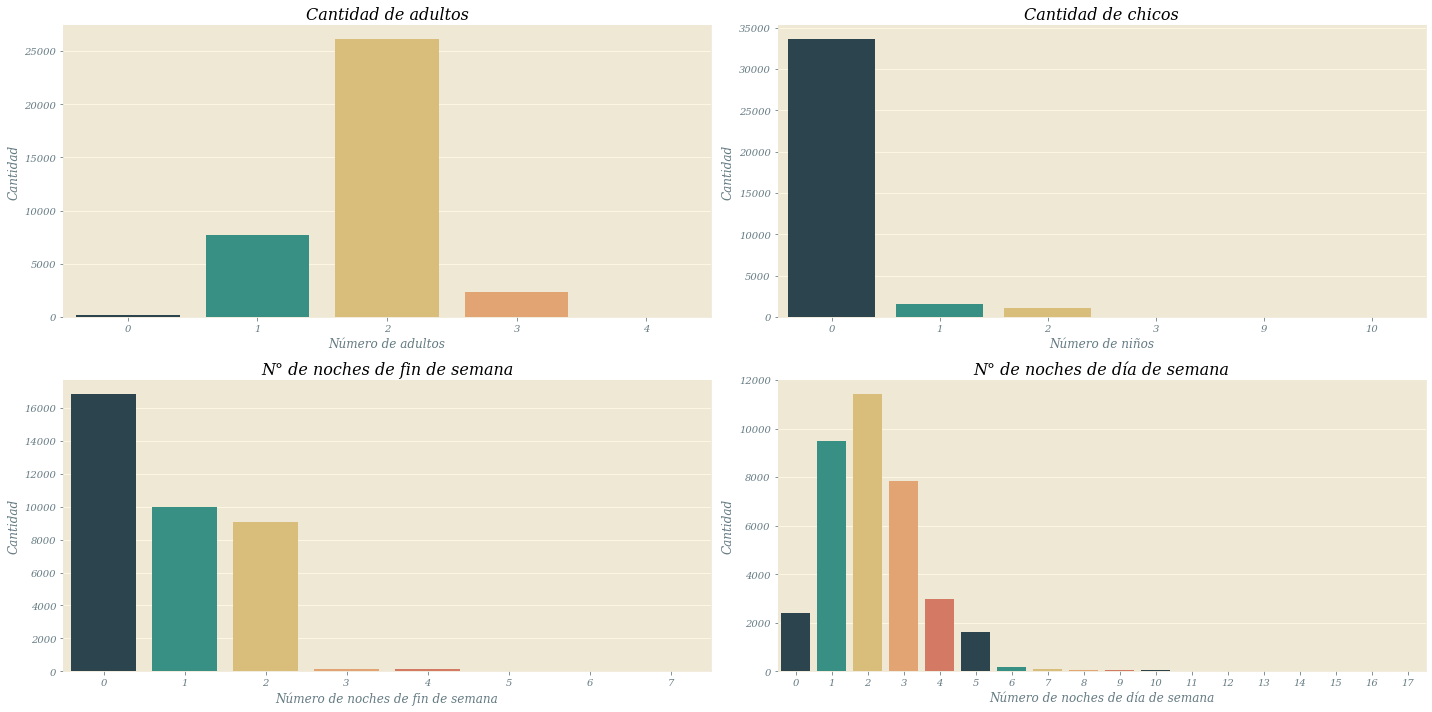

In [40]:
plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
plt.gca().set_title('Cantidad de adultos')
sns.countplot(data=df_reserva_hoteles, x = 'no_of_adults', palette = paleta_colores)
plt.xlabel('Número de adultos')
plt.ylabel('Cantidad')

plt.subplot(2,2,2)
plt.gca().set_title('Cantidad de chicos')
sns.countplot(data=df_reserva_hoteles, x = 'no_of_children', palette = paleta_colores)
plt.xlabel('Número de niños')
plt.ylabel('Cantidad')

plt.subplot(2,2,3)
plt.gca().set_title('N° de noches de fin de semana')
sns.countplot(data=df_reserva_hoteles, x = 'no_of_weekend_nights', palette = paleta_colores)
plt.xlabel('Número de noches de fin de semana')
plt.ylabel('Cantidad')

plt.subplot(2,2,4)
plt.gca().set_title('N° de noches de día de semana')
sns.countplot(data=df_reserva_hoteles, x = 'no_of_week_nights', palette = paleta_colores)
plt.xlabel('Número de noches de día de semana')
plt.ylabel('Cantidad')

print('La mayor parte de los huéspedes alquilan habitaciones para dos adultos y sin chicos. \nExisten relativamente pocos registros de reservas con chicos. \nLa estadía no suele superar más de una semana.\n')

plt.tight_layout()
plt.show()

In [41]:
n_cancelaciones = df_reserva_hoteles.no_of_previous_cancellations.value_counts().sort_index()
n_cancelaciones
print(f'Número de cancelaciones prevías por huésped: \n\n{pd.DataFrame(n_cancelaciones)}\n\nPor ejemplo, cuatro huéspedes cancelaron 13 veces')

Número de cancelaciones prevías por huésped: 

    no_of_previous_cancellations
0                          35937
1                            198
2                             46
3                             43
4                             10
5                             11
6                              1
11                            25
13                             4

Por ejemplo, cuatro huéspedes cancelaron 13 veces


Huéspedes que solicitan un espacio de estacionamiento, o huéspedes que 
se han hospedado anteriormente son huéspedes que generalmente no cancelan la reserva. 
Además, los huéspedes que solicitan más solicitudes especiales son menos propensos a cancelar.



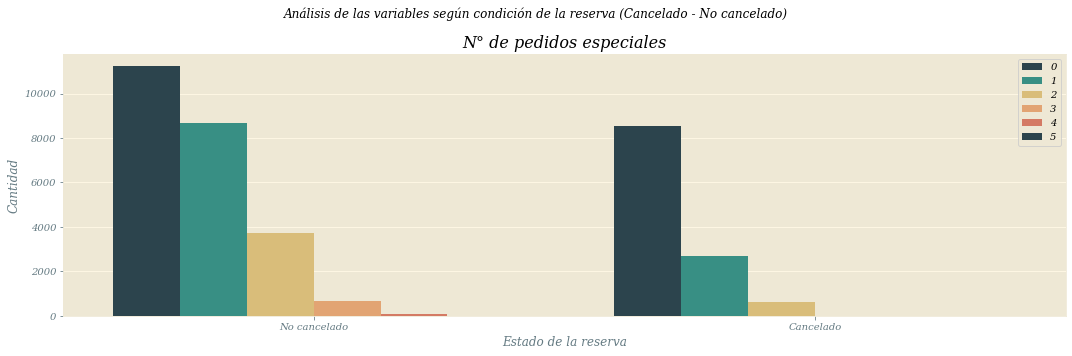

In [42]:
plt.figure(figsize = (15, 5))
plt.suptitle("Análisis de las variables según condición de la reserva (Cancelado - No cancelado)")

plt.subplot(1,1,1)
ax = sns.countplot(x = 'booking_status', hue = 'no_of_special_requests', palette = paleta_colores, data = df_reserva_hoteles)
plt.title('N° de pedidos especiales')
plt.legend(labels=['0', '1', '2', '3', '4', '5'], loc='upper right')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Estado de la reserva')
plt.xticks(ticks=[0, 1], labels=['No cancelado', 'Cancelado'])


plt.tight_layout()
print('Huéspedes que solicitan un espacio de estacionamiento, o huéspedes que \nse han hospedado anteriormente son huéspedes que generalmente no cancelan la reserva. \nAdemás, los huéspedes que solicitan más solicitudes especiales son menos propensos a cancelar.\n')

Se observan valores bajos de correlación entre las variables
Valido para variables numéricas


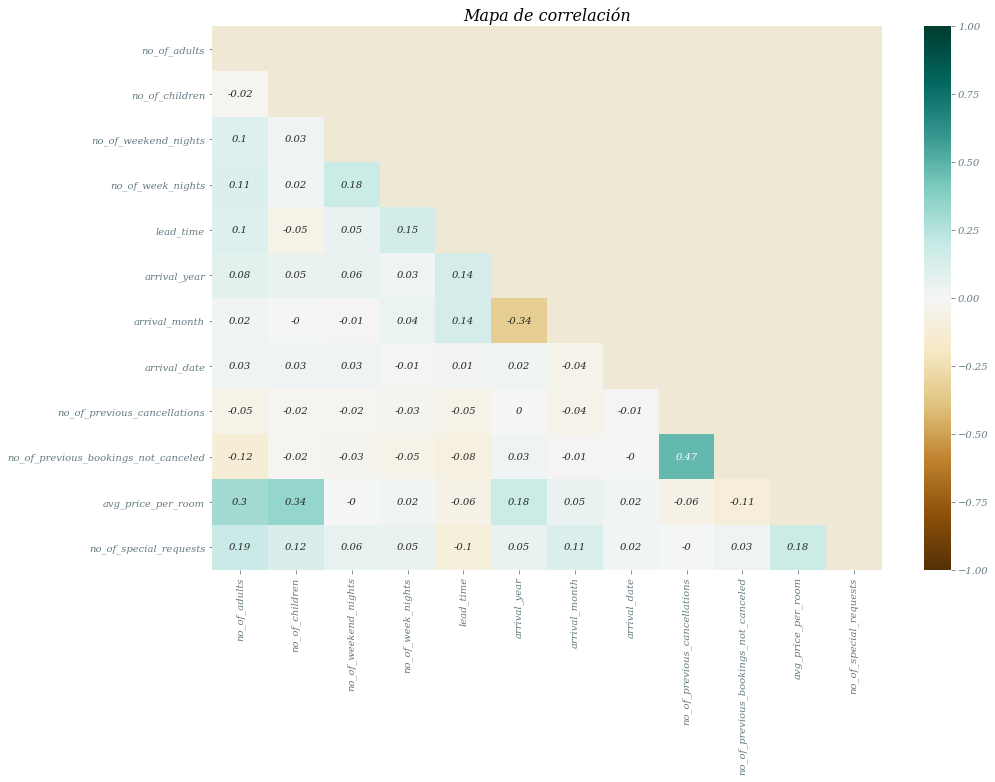

In [43]:
correlation_matrix = round(df_reserva_hoteles.corr(),2)
mask = np.triu(np.ones_like(df_reserva_hoteles.corr()))
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', mask=mask, vmin=-1, vmax=1)
plt.title('Mapa de correlación')
print('Se observan valores bajos de correlación entre las variables\nValido para variables numéricas')

plt.show()

El coeficiente de correlación entre el precio promedio por habitación y el tiempo 
transcurrido desde la reserva y la llegada al hotel es: -0.06
Es decir que no hay correlación entre ambas variables


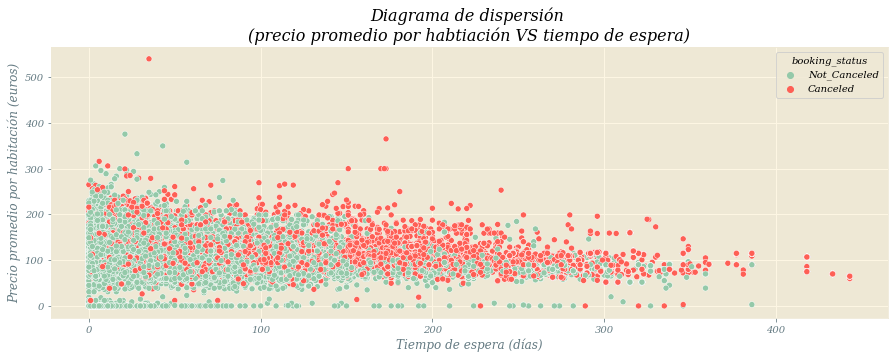

In [44]:
plt.figure(figsize = (15, 5))

ax = sns.scatterplot(data=df_reserva_hoteles, x="lead_time", y="avg_price_per_room", palette=['#94c9a9', '#fe5f55'], hue = 'booking_status')
correlation_coef = df_reserva_hoteles['lead_time'].corr(df_reserva_hoteles['avg_price_per_room'])

plt.title('Diagrama de dispersión \n(precio promedio por habtiación VS tiempo de espera)')
ax.set_xlabel('Tiempo de espera (días)')
ax.set_ylabel('Precio promedio por habitación (euros)')

print(f'El coeficiente de correlación entre el precio promedio por habitación y el tiempo \ntranscurrido desde la reserva y la llegada al hotel es: {correlation_coef.round(2)}\nEs decir que no hay correlación entre ambas variables')


plt.show()

## Resultados



*   La cantidad de reservas canceladas fué de 11885 (32.76%)
y de 24390 (67.24%) para las reservas no canceladas para ambos años en conjunto.

*   El porcentaje de reservas canceladas en el 2017 fue del 14.75 % y en el 2018 del 36.71 %, por lo que hubo un aumento en las cancelaciones del 21.96 %

*   Se puede observar que en el 2018 aumentaron la cantidad de reservas para cada mes en comparación del año 2017. Además, no hay datos en los meses previos a Julio para el año 2017. El mes con mayor cantidad de reservas, tanto para 2017 y 2018 es octubre.


*   En el gráfico de "Cantidad de reservas por mes", si se tiene en cuenta los años 2017 y 2018 en conjunto se puede observar que hay una tendencia alcista de reservas desde enero hasta el mes de octubre y para noviembre empieza a decaer.

*   En el boxplot de precios promedios por habitación se observan valores con mediana igual a 99.45 euros. El primer cuantil (25%) es 80.3 euros y el tercer cuantil 120.0 euros. Se detectaron datos anómalos.

*   El promedio de pedidos especiales para las reservas no canceladas es 0.76 y de  0.33 para las canceladas, indicando que si el número de solicitudes especiales aumenta, es menos probable que las personas cancelen su reserva.

*   Las medidas estadísticas son mayores para los casos de las reservas canceladas que para aquellas no canceladas en el campo de precio promedio por habitación, como se observa en el histograma y en el boxplot. A modo de ejemplo, el valor para la mediana en el caso de que la reserva no haya sido cancelada es de 95.0 euros y de 108.0 euros para aquellas canceladas. Se podría confirmar con un test de hipótesis.

*   Se observa que la mayoría de los usuarios eligen el tipo de comida del plan 1 y contratan habitaciones de tipo 1, siendo la reservación  mayormente online.


*   Complementando al punto anterior, la mayor cantidad de reservas son para dos adultos y en la mayoría de los casos sin niños.



*   Como el porcentaje de los datos anómalos es relativamente chico respecto al total de registros, se decidió no excluir estos registros del análisis



*   Huéspedes que solicitan un espacio de estacionamiento, o huéspedes que
se han hospedado anteriormente son huéspedes que generalmente no cancelan la reserva.
Además, los huéspedes que solicitan más solicitudes especiales son menos propensos a cancelar.







#### Reducción de dimensionalidad utilizando análisis factorial de datos mixtos (FAMD). 
Para este método de reducción de dimensionalidad no hace falta normalizar o estandarizar las variables.

In [45]:
# La biblioteca Prince no deja plottear FAMD para una fuente de datos con más de 5 mil registros:
# "The number of rows in your dataset is greater than the maximum allowed (5000)."
# Por lo tanto para Reducción de dimensionalidad me quedo con un 5 mil registros al azar. 

# Seleccionar 5000 registros al azar
sampled_data = df_reserva_hoteles.sample(n=5000, random_state=42)

In [46]:
# Aplico FAMD (Reducción de dimensionalidad para variables mixtas, es decir, mezcla de variables numéricas y categoricas) 
data_sin_na = sampled_data.dropna().drop('booking_status', axis = 1)
famd = prince.FAMD(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(data_sin_na)

In [47]:
print('La varianza explicada por estas dos componentes es muy chica')
famd.eigenvalues_summary

La varianza explicada por estas dos componentes es muy chica


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,24.420,0.70%,0.70%
1,20.738,0.59%,1.29%


In [48]:
print(famd.column_coordinates_[0].sort_values()) # Ordeno de menor a mayor los pesos de la primer componente

print(f'\nLas variables más relevantes son aquellas con más peso:\n{famd.column_coordinates_[0].sort_values().index[-2:].to_list()}')

variable
required_car_parking_space              0.002944
type_of_meal_plan                       0.003598
arrival_year                            0.012323
no_of_children                          0.020545
arrival_date                            0.026333
no_of_special_requests                  0.037759
no_of_weekend_nights                    0.052970
room_type_reserved                      0.055855
arrival_month                           0.061400
no_of_week_nights                       0.099592
avg_price_per_room                      0.099622
no_of_adults                            0.261852
lead_time                               0.284218
no_of_previous_cancellations            0.331144
market_segment_type                     0.441037
no_of_previous_bookings_not_canceled    0.658818
repeated_guest                          0.689706
Name: 0, dtype: float64

Las variables más relevantes son aquellas con más peso:
['no_of_previous_bookings_not_canceled', 'repeated_guest']


In [49]:
print('En verde se plotean las columnas, en azul las observaciones.\nSe observan al menos dos grupos (o clusters) concentrados de observaciones. ')
famd.plot(
    data_sin_na,
    x_component=0,
    y_component=1
)

En verde se plotean las columnas, en azul las observaciones.
Se observan al menos dos grupos (o clusters) concentrados de observaciones. 


alt.LayerChart(...)

#### Feature Engineering a partir de las columnas de Año, Mes y Día.


Resumiendo: Creo una columna Fecha (con formato %Y-%m-%d) a partir de las tres columnas correspondientes al año, mes y día. 

Con la columna Fecha creo una variable categorica con los valores de la semana (Monday, Tuesday, etc) y luego elimino las columnas año, mes y día.

In [50]:
df_reserva_hoteles['Fecha'] = pd.to_datetime(df_reserva_hoteles['arrival_year'].astype('str') + '-' + df_reserva_hoteles['arrival_month'].astype('str') + '-' + df_reserva_hoteles['arrival_date'].astype('str'), format='%Y-%m-%d', errors='coerce')


In [51]:
# Encuentra las filas con fechas inválidas
fechas_incorrectas = df_reserva_hoteles[df_reserva_hoteles['Fecha'].isna()]

# Muestra las filas con fechas inválidas
print("Registros con fechas inválidas:")
print(fechas_incorrectas[['arrival_year', 'arrival_month','arrival_date']])

Registros con fechas inválidas:
            arrival_year  arrival_month  arrival_date
Booking_ID                                           
INN02627            2018              2            29
INN03678            2018              2            29
INN05601            2018              2            29
INN06344            2018              2            29
INN07649            2018              2            29
INN08001            2018              2            29
INN08990            2018              2            29
INN09154            2018              2            29
INN09246            2018              2            29
INN09665            2018              2            29
INN09935            2018              2            29
INN10594            2018              2            29
INN10653            2018              2            29
INN10748            2018              2            29
INN11882            2018              2            29
INN13959            2018              2           

In [52]:
df_reserva_hoteles = df_reserva_hoteles.dropna(subset=['Fecha']) # Elimino todos esos registros, ya que la fecha es incorrecta. 

In [53]:
df_reserva_hoteles['day_of_week'] = df_reserva_hoteles['Fecha'].dt.strftime('%A').astype('category')

In [54]:
df_reserva_hoteles.drop(['arrival_year', 'arrival_month', 'arrival_date', 'Fecha'], axis = 1, inplace=True) # Elimino del set de datos las varibles de fecha


#### Feature Engineering: Normalización de variables y conversión de variables categoricas a numéricas (One Hot Encoding)

In [55]:
df_reserva_hoteles_copia = df_reserva_hoteles.copy()

##### Reemplazo los valores categoricos de la variable objetivo por valores numéricos

In [56]:
# Reemplazo la variable objetivo por 0 y 1

df_reserva_hoteles_copia['booking_status'] = df_reserva_hoteles_copia['booking_status'].replace({'Not_Canceled':0, 'Canceled':1}) 

##### Conversión de variables categoricas a numéricas (One Hot Encoding)

In [57]:
df_reserva_hoteles_copia = pd.get_dummies(df_reserva_hoteles_copia, drop_first=False)

##### Normalización de las variables numéricas

In [58]:
print(f'Estandarizo las variables numéricas:\n\n{df_reserva_hoteles_copia.columns.to_list()[0:9]}')
variables_a_estandarizar = df_reserva_hoteles_copia.columns.to_list()[0:9]

Estandarizo las variables numéricas:

['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


In [59]:
#Estandarización de variables numéricas: 

df_reserva_hoteles_copia[variables_a_estandarizar] = (df_reserva_hoteles_copia[variables_a_estandarizar] - np.mean(df_reserva_hoteles_copia[variables_a_estandarizar]))/np.std(df_reserva_hoteles_copia[variables_a_estandarizar])

#### Implementación de algoritmos de Machine Learning

In [60]:
X = df_reserva_hoteles_copia.drop(columns=['booking_status']) # Me quedo con todos los datos menos con la varible target
y = df_reserva_hoteles_copia['booking_status']              # Variable target
random_state = 1

In [61]:
# Separamos en entrenamiento/test en razon 80/20 %

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False) 

# random_state es una forma de que si hay mezcla, sea siempre de la misma manera.

En Cross Validation, por ejemplo KFold se le pasan los datos de train. Los de Test no se tocan hasta el final, ni para calcular hiperparametros.
CV nos va a permitir ajustar los hiperparametros de los modelos

In [62]:
strat_kfold = StratifiedKFold(n_splits=5) # Creo el procedimiento StratifiedKFold de cross validation (variable target desbalanceada)

In [63]:
# scores = cross_val_score(modelo, X_train, y_train, scoring='f1', cv=cv, verbose=1) 

# grid_cv = RandomizedSearchCV(model, params_grid, scoring='f1', n_jobs=-1, cv=cv)
# grid_cv.fit(X_train, y_test)
# grid_cv.best_params_
# grid_cv.best_score_ # El .predict hay que hacerselo a grid_cv que es tu modelo pero con los datos de test

In [67]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier #pip install xgboost

In [74]:
# Agrego cada uno de los modelos instanciados en una lista

classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(XGBClassifier())

In [69]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "f1", cv = strat_kfold, n_jobs=-1))

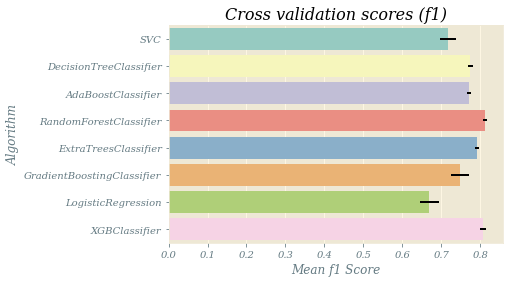

In [73]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTreeClassifier","AdaBoostClassifier",
"RandomForestClassifier","ExtraTreesClassifier","GradientBoostingClassifier","LogisticRegression", "XGBClassifier"]})

g = sns.barplot("CrossValMeans","Algorithm", data = cv_res, palette="Set3", orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean f1 Score")
g = g.set_title("Cross validation scores (f1)")

In [91]:
cv_res.loc[cv_res.CrossValMeans.nlargest(5).index]

,CrossValMeans,CrossValerrors,Algorithm
3,0.813192,0.005489,RandomForestClassifier
7,0.806587,0.007606,XGBClassifier
4,0.791725,0.004401,ExtraTreesClassifier
1,0.774086,0.006502,DecisionTreeClassifier
2,0.770934,0.005923,AdaBoostClassifier


#### Hypertuning de parámetros para los mejores 3 modelos:

1- RandomForestClassifier

2- XGBClassifier

3- ExtraTreesClassifier

In [101]:
RFC = RandomForestClassifier()


# RandomizedSearchCV con los siguientes hiperparametros:

rf_param_random_search = {"max_depth": [None],
                        "max_features": [1, 3, 10],
                        "min_samples_split": [2, 3, 10],
                        "min_samples_leaf": [1, 3, 10],
                        "bootstrap": [False],
                        "n_estimators" :[100,300],
                        "criterion": ["gini"]}


random_search_RFC = RandomizedSearchCV(RFC, param_distributions = rf_param_random_search, cv=strat_kfold, scoring="f1", n_jobs= -1, verbose = 1)

random_search_RFC.fit(X_train, y_train)

RFC_best = random_search_RFC.best_estimator_ # Devuelve el modelo con los mejores parametros encontrados con RandomizedSearchCV

# Best score
print(f'El mejor f1 Score con el método RandomizedSearchCV es de: {random_search_RFC.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


El mejor f1 Score con el método RandomizedSearchCV es de: 0.8204023652784371


In [ ]:
y_test_pred = RFC_best.predict(X_test)
f1_RFC = f1_score(y_test, y_test_pred)
f1_RFC

In [ ]:
Xgb = XGBClassifier()


# RandomizedSearchCV con los siguientes hiperparametros:

xgb_param_random_search = {"max_depth": [None],
                        "max_features": [1, 3, 10],
                        "min_samples_split": [2, 3, 10],
                        "min_samples_leaf": [1, 3, 10],
                        "bootstrap": [False],
                        "n_estimators" :[100,300],
                        "criterion": ["gini"]}


random_search_Xgb = RandomizedSearchCV(Xgb, param_distributions = xgb_param_random_search, cv=strat_kfold, scoring="f1", n_jobs= -1, verbose = 1)

random_search_Xgb.fit(X_train,y_train)

Xgb_best = random_search_Xgb.best_estimator_

# Best score
random_search_Xgb.best_score_

In [ ]:
y_test_pred = Xgb_best.predict(X_test)
f1_Xgb = f1_score(y_test, y_test_pred)
f1_Xgb

In [102]:
ExtC = ExtraTreesClassifier()


# RandomizedSearchCV con los siguientes hiperparametros:

ex_param_random_search = {"max_depth": [None],
                        "max_features": [1, 3, 10],
                        "min_samples_split": [2, 3, 10],
                        "min_samples_leaf": [1, 3, 10],
                        "bootstrap": [False],
                        "n_estimators" :[100,300],
                        "criterion": ["gini"]}


random_search_ExtC = RandomizedSearchCV(ExtC, param_distributions = ex_param_random_search, cv=strat_kfold, scoring="f1", n_jobs= -1, verbose = 1)

random_search_ExtC.fit(X_train,y_train)

ExtC_best = random_search_ExtC.best_estimator_

# Best score
random_search_ExtC.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.8045618595996791

In [103]:
y_test_pred = ExtC_best.predict(X_test)
f1_ExtC = f1_score(y_test, y_test_pred)
f1_ExtC

0.8055555555555555